
# 1. Data preparation

In addition to the hotspot destinations, it is also important to understand what are the main migration patterns within the different neighborhoods. This information will allow us to determine the primary routes of transport.
For clarity, we will start by selecting only routes between neighborhoods with more than 10,000 in the six-month period of the study. This will allow us to focus on the main routes and discard all the other ones that were not so common.
Figure 6.1 presents a summary of the neighborhoods that concentrate the main transportation routes in the city. It is clear that most of the taxi trips are concentrate in Midtown Manhattan and the Upper East/West side.
This information, combined with the hotspots of chapter 5, allow us to significantly reduce our target area where the e-Trike will be operating since most of the traffic will be enclosed in a 10-square kilometer area.


## 1.1 Import Libraries 

In [2]:
# install.packages("rgeos",repos = "http://cran.us.r-project.org")
library(circlize, quietly = TRUE, warn.conflicts = FALSE)
library(migest, quietly = TRUE, warn.conflicts = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE) #data visualization
library(ggmap, quietly = TRUE, warn.conflicts = FALSE)
library(data.table, quietly = TRUE, warn.conflicts = FALSE) # for fast data processing
library(dplyr, quietly = TRUE, warn.conflicts = FALSE) # data manipulation
library(lubridate, quietly = TRUE, warn.conflicts = FALSE)
library(chron, quietly = TRUE, warn.conflicts = FALSE) #handling of dates
library(RColorBrewer, quietly = TRUE, warn.conflicts = FALSE)
library(stringr, quietly = TRUE, warn.conflicts = FALSE)
library(rgdal, quietly = TRUE, warn.conflicts = FALSE) 
library(sp, quietly = TRUE, warn.conflicts = FALSE) 
library(rgeos, quietly = TRUE, warn.conflicts = FALSE) 
library(maptools, quietly = TRUE, warn.conflicts = FALSE) 
gpclibPermit()

[1] FALSE

## 1.3 Import data

In [3]:
data <- fread('c:/datasets/NYCtaxi_cleaned_data.csv', sep=",", stringsAsFactors=F)

data <- data  %>% 
  mutate_at("pickup_county", funs(as.factor)) %>% 
  mutate_at("dropoff_county", funs(as.factor)) %>% 
  filter(pickup_county == "New York" & dropoff_county=="New York") %>%
  mutate_at("dataset", funs(as.factor)) %>% 
  mutate_at("holiday", funs(as.factor)) %>% 
  mutate(date         = date(date), 
         weekday      = lubridate::wday(date, label=TRUE),
         weekend      = is.weekend(date),
         month        = month(date, label = TRUE, abbr = FALSE))

Read 1815361 rows and 25 (of 25) columns from 0.324 GB file in 00:00:13


In [4]:
a <- data %>%
  group_by(pickup_neighborhood,dropoff_neighborhood) %>%
  summarise(flow = sum(passenger_count)) %>%
  rename(orig_reg = pickup_neighborhood, dest_reg=dropoff_neighborhood) %>%
  filter(flow >= 10000)

a <- a  %>% filter(dest_reg %in% a$orig_reg)

a <- data.frame(a)
str(a)
sum(a$flow)

'data.frame':	30 obs. of  3 variables:
 $ orig_reg: chr  "Carnegie Hill" "Chelsea" "Chelsea" "Chelsea" ...
 $ dest_reg: chr  "Upper East Side" "Chelsea" "Flatiron District" "Midtown" ...
 $ flow    : int  11349 12607 10234 10723 11022 10498 11630 11056 19109 10644 ...


[1] 697687

png 
  2

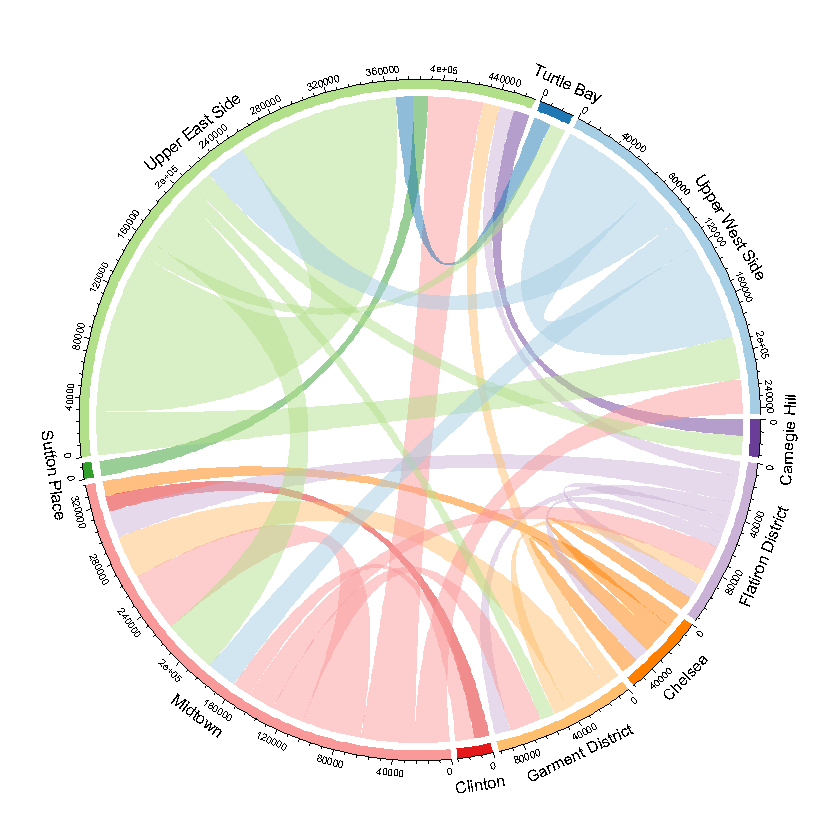

In [5]:
hm_palette <- colorRampPalette(rev(brewer.pal(10, 'Paired')), space='Lab')  
col1 = hm_palette(length(unique(a$orig_reg)))

chordDiagram(x = a,col1, order = c('Carnegie Hill', 'Flatiron District', 'Chelsea', 'Garment District','Clinton','Greenwich Village', 'Midtown', 'Sutton Place',  'Upper East Side','Turtle Bay', 'Upper West Side'))
dev.print(png, file = "c:/datasets/hola.png", height=25, width=25, units = "cm", res=1000)

In [19]:
unique(a$orig_reg)

[1] "Carnegie Hill"     "Chelsea"           "Clinton"          
 [4] "Flatiron District" "Garment District"  "Greenwich Village"
 [7] "Midtown"           "Murray Hill"       "Sutton Place"     
[10] "Turtle Bay"        "Upper East Side"   "Upper West Side"

In [61]:
hm_palette <- colorRampPalette(rev(brewer.pal(10, 'Paired')), space='Lab')  

b <- data.frame(region = unique(a$orig_reg),
                 order1 = as.integer(seq(1,length(unique(a$orig_reg)),1)),
                  col1 = hm_palette(length(unique(a$orig_reg))))

i <- sapply(b, is.factor)
b[i] <- lapply(b[i], as.character)

b$reg1 <- word(b$region,1) 
b$reg2 <- word(b$region,2,-1)

# b <- b[c("region","order1","col1","reg1","reg2")]

str(df1)
str(b)

'data.frame':	9 obs. of  5 variables:
 $ region: chr  "Northern America" "Africa" "Europe" "Eastern Europe & Central Asia" ...
 $ order1: int  1 2 3 4 5 6 7 8 9
 $ col1  : chr  "#40A4D8" "#33BEB7" "#B2C224" "#FECC2F" ...
 $ reg1  : chr  "Northern" "Africa" "Europe" "Eastern Europe" ...
 $ reg2  : chr  "America" "" "" "& Central Asia" ...
'data.frame':	9 obs. of  5 variables:
 $ region: chr  "Carnegie Hill" "Chelsea" "Clinton" "Flatiron District" ...
 $ order1: int  1 2 3 4 5 6 7 8 9
 $ col1  : chr  "#6A3D99" "#D6ABBE" "#FF8F29" "#F78D4E" ...
 $ reg1  : chr  "Carnegie" "Chelsea" "Clinton" "Flatiron" ...
 $ reg2  : chr  "Hill" NA NA "District" ...


In [5]:
# Import neighborhood data
ny.map <- readOGR("c:/datasets/ZillowNeighborhoods-NY.shp", layer = "ZillowNeighborhoods-NY")
neighborhoods <- ny.map[ny.map$City == c("New York"), ]

# Subset only the target neighborhoods
counties = c("New York","Queens","Kings","Bronx")
m <- neighborhoods[neighborhoods$County %in% counties,]

#  Convert from SpatialPolygonsDataFrame to r dataframe
ny.f = m %>% fortify(region = 'Name')
NY.n  = merge(ny.f, m@data, by.x = 'id', by.y = 'Name')

# Create the target value to be analysed
values <-data %>%
  group_by(pickup_neighborhood,dropoff_neighborhood) %>%
  summarise(flow = sum(passenger_count)) %>%
  filter(flow >= 8000) %>%
  group_by(pickup_neighborhood)   %>%
  summarise(flow = sum(flow))

# Join the values with the coordinate dataframe
values <- inner_join(NY.n , values, by = c("id"="pickup_neighborhood"))

OGR data source with driver: ESRI Shapefile 
Source: "c:/datasets/ZillowNeighborhoods-NY.shp", layer: "ZillowNeighborhoods-NY"
with 579 features
It has 5 fields


### Main Neghborhoods

Figure 6.1 presents a summary of the neighborhoods that concentrate the main transportation routes in the city. It is clear that most of the taxi trips are concentrate in Midtown Manhattan and the Upper East/West side.
This information, combined with the hotspots of chapter 5, allow us to significantly reduce our target area where the e-Trike will be operating since most of the traffic will be enclosed in a 10-square kilometer area.


Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

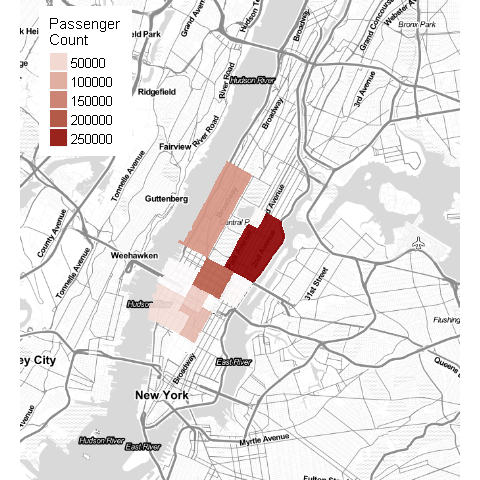

In [13]:
options(repr.plot.width=4, repr.plot.height=4)

box <- c(left = -74.08, bottom = 40.68, right = -73.85, top = 40.87)
map <- get_stamenmap(box, zoom = 12, maptype = "toner-lite")

ggmap(map, extent = "device") +
    geom_polygon(aes(fill = flow, x = long, y = lat, group = group), data = values, alpha = 0.9, color = NA) +
    scale_fill_gradient(low="white", high ="darkred") +
    guides(fill=guide_legend(title="Passenger\nCount",title.hjust = 0)) +
    theme(legend.position=c(0.15, 0.83),legend.title=element_text(size=9),legend.text=element_text(size=8),legend.key.size = unit(.4, "cm"))
    